In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast import GridGenerator
from scalecast.util import plot_reduction_errors
from statsmodels.tsa.stattools import adfuller

In [2]:
sns.set(rc={"figure.figsize": (12, 8)})

GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

In [3]:
df = pd.read_csv("IAH-Dom-Multivariate.csv", parse_dates=["Date"])
f = Forecaster(
    y=df["PASSENGERS"],
    current_dates=df["Date"],
    require_future_dates = False,
)
f.set_test_length(24)

f.add_seasonal_regressors(
    'month',
    raw=False,
    sincos=True
)
f.integrate(train_only=True)
f.add_time_trend()
f.add_poly_terms('t',pwr=3)

f

Forecaster(
    DateStartActuals=2001-01-01T00:00:00.000000000
    DateEndActuals=2021-09-01T00:00:00.000000000
    Freq=MS
    N_actuals=249
    ForecastLength=NA
    Xvars=['monthsin', 'monthcos', 't', 't^2', 't^3']
    Differenced=1
    TestLength=24
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [4]:
df_stationary = df.drop('PASSENGERS',axis=1).set_index('Date')
exclude = (
    'Recession',
    'post_covid',
    'post_vaccine',
    'post_delta',
)
diffs = {
    c:0 for c in df_stationary if c not in exclude
}
for c in diffs:
    series = df_stationary[c]
    while adfuller(series)[1] >= 0.05:
        df_stationary[c] = df_stationary[c].diff()
        series = df_stationary[c].dropna()
        diffs[c] += 1

for k, v in diffs.items():
    print(f'column: {k} differenced: {v} time(s)')
    
df_stationary = df_stationary.dropna()

column: Number of available seats Domestic and international level differenced: 0 time(s)
column: Number of domestic flights differenced: 1 time(s)
column: Number of International  flights differenced: 1 time(s)
column: Revenue Passenger-miles/Domestic differenced: 0 time(s)
column: Revenue Passenger-miles/International differenced: 1 time(s)
column: TSI/Passengers differenced: 1 time(s)
column: TSI/Freight differenced: 1 time(s)
column: Trade, Transportation, and Utilities differenced: 1 time(s)
column: All employees Information differenced: 0 time(s)
column: Employees In financial activities differenced: 1 time(s)
column: Employees in Government  differenced: 1 time(s)
column: Employees in Leisure and Hospitality differenced: 1 time(s)
column: All Employees,Education and Health Services differenced: 1 time(s)
column: All Employee,Mining and Logging: Oil and Gas Extraction differenced: 2 time(s)
column: Employees in Other Services differenced: 1 time(s)
column: Unemployement Rate in H

In [5]:
f.keep_smaller_history(df_stationary.reset_index()['Date'].min())
f.ingest_Xvars_df(df_stationary.reset_index(),date_col='Date')

In [6]:
f

Forecaster(
    DateStartActuals=2001-03-01T00:00:00.000000000
    DateEndActuals=2021-09-01T00:00:00.000000000
    Freq=MS
    N_actuals=247
    ForecastLength=NA
    Xvars=['monthsin', 'monthcos', 't', 't^2', 't^3', 'Number of available seats Domestic and international level', 'Number of domestic flights', 'Number of International  flights', 'Revenue Passenger-miles/Domestic', 'Revenue Passenger-miles/International', 'TSI/Passengers', 'TSI/Freight', 'Trade, Transportation, and Utilities', 'All employees Information', 'Employees In financial activities', 'Employees in Government ', 'Employees in Leisure and Hospitality', 'All Employees,Education and Health Services', 'All Employee,Mining and Logging: Oil and Gas Extraction', 'Employees in Other Services', 'Unemployement Rate in Houston Area', 'Texas Business CyclesIndex', 'PCE on Durable goods(Billions of Dollars, Monthly, Seasonally Adjusted Annual Rate)', 'PCE on Recreational activities', 'Recession', 'WTO Oil Price', 'post_covid', 

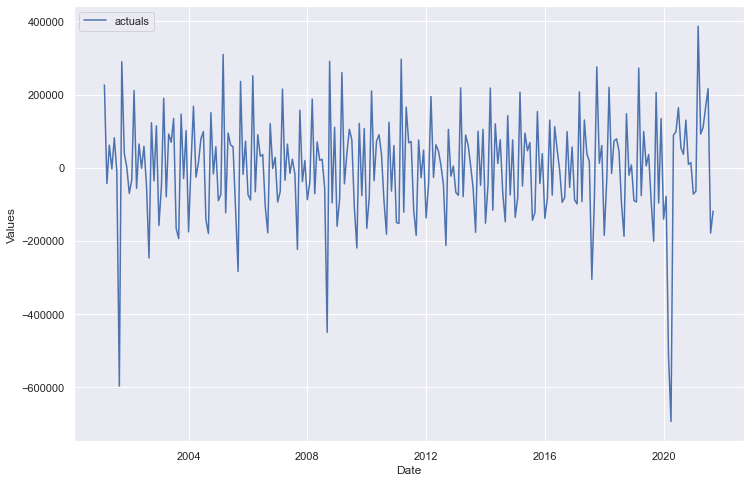

In [7]:
f.plot()
plt.show()

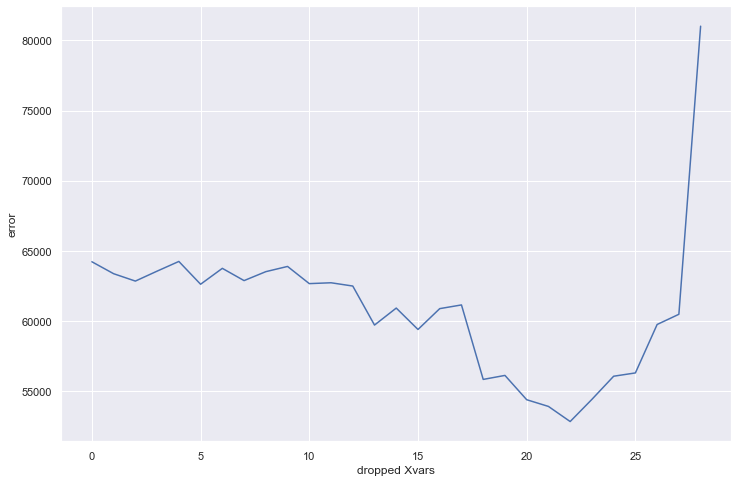

In [8]:
f.reduce_Xvars(
    estimator='gbt',
    method='shap',
    cross_validate=True,
    cvkwargs = {'k':3},
    dynamic_tuning = 6,
    overwrite = True,
    grid_search=False,
)

plot_reduction_errors(f)
plt.show()

In [9]:
selected_vars = f.reduced_Xvars
selected_vars

['monthsin',
 'monthcos',
 'Number of domestic flights',
 'Number of International  flights',
 'Revenue Passenger-miles/International',
 'TSI/Passengers',
 'PCE on Recreational activities']

In [10]:
df_selected = df.set_index('Date')[[c for c in selected_vars if c in df]]
df_selected.head()

,Number of domestic flights,Number of International flights,Revenue Passenger-miles/International,TSI/Passengers,PCE on Recreational activities
Date,,,,,
2001-01-01,718557.9639,64255.44712,18682646.35,100.3,19089.0
2001-02-01,718557.9639,64255.44712,18682646.35,100.3,19089.0
2001-03-01,718557.9639,64255.44712,18682646.35,100.8,19089.0
2001-04-01,718557.9639,64255.44712,18682646.35,101.4,19089.0
2001-05-01,718557.9639,64255.44712,18682646.35,101.9,19089.0


In [11]:
forecasters = {}
f = Forecaster(
    y=df['PASSENGERS'],
    current_dates=df['Date'],
)
f.generate_future_dates(24)
f.add_seasonal_regressors(
    'month',
    sincos=True,
    raw=False
)

f.diff()

forecasters['PASSENGERS'] = f

for c in df_selected:
    f = Forecaster(
        y=df_selected[c],
        current_dates=df_selected.index,
    )
    f.integrate()
    forecasters[c] = f
    
mvf = MVForecaster(
    *forecasters.values(),
    names=forecasters.keys(),
)
mvf.set_optimize_on('PASSENGERS')
mvf.set_test_length(24)
mvf

MVForecaster(
    DateStartActuals=2001-01-01T00:00:00.000000000
    DateEndActuals=2021-09-01T00:00:00.000000000
    Freq=MS
    N_actuals=249
    N_series=6
    SeriesNames=['PASSENGERS', 'Number of domestic flights', 'Number of International  flights', 'Revenue Passenger-miles/International', 'TSI/Passengers', 'PCE on Recreational activities']
    ForecastLength=24
    Xvars=['monthsin', 'monthcos']
    TestLength=24
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=PASSENGERS
)

In [12]:
models = (
    'xgboost',
    'mlr',
    'lightgbm',
    'sgd',
    'elasticnet',
    'svr',
    'mlp',
)

mvf.tune_test_forecast(
    models,
    cross_validate=True,
    k=3,
    dynamic_tuning=6,
    probabilistic=True,
    limit_grid_size=.25,
)

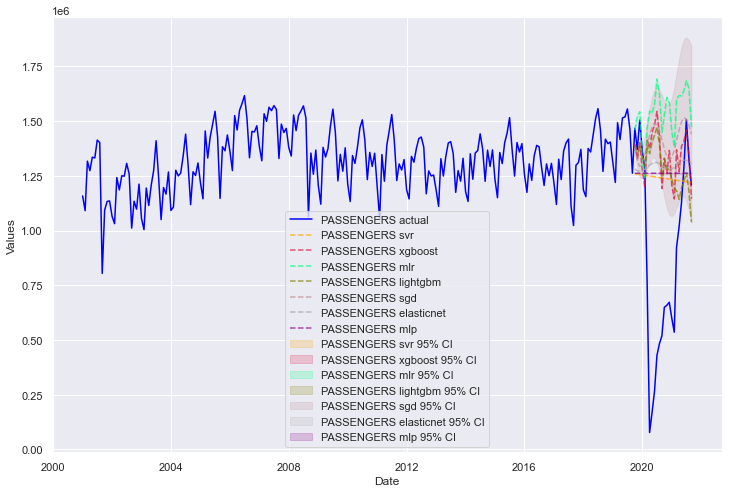

In [13]:
mvf.set_best_model(determine_best_by='LevelTestSetRMSE')
mvf.plot_test_set(
    put_best_on_top=True,
    series='PASSENGERS',
    level=True,
    #models=mvf.best_model,
    ci=True,
)
plt.show()

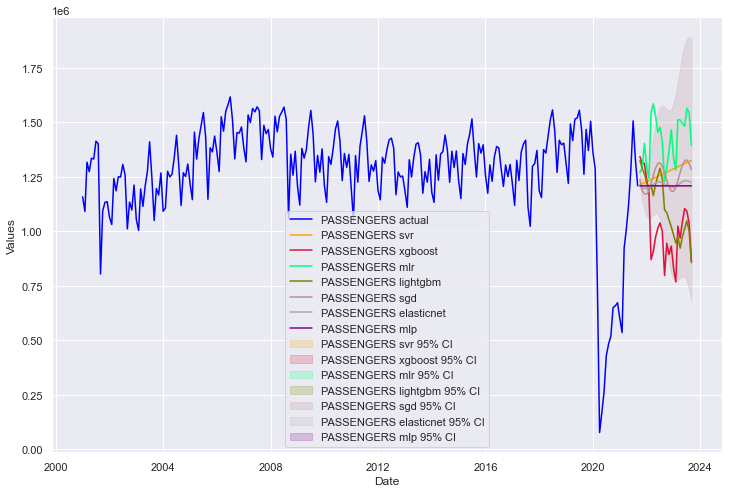

In [14]:
mvf.plot(
    put_best_on_top=True,
    series='PASSENGERS',
    #models=mvf.best_model,
    level=True,
    ci=True,
)
plt.show()

In [15]:
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'Lags',
        'ValidationMetricValue',
        'LevelTestSetRMSE'
    ]
]

,ModelNickname,Series,HyperParams,Lags,ValidationMetricValue,LevelTestSetRMSE
0,svr,PASSENGERS,"{'kernel': 'linear', 'C': 1, 'epsilon': 0.5}",3,128101.306986,5.686331e+05
1,xgboost,PASSENGERS,"{'n_estimators': 200, 'scale_pos_weight': 5, '...",1,108018.545591,6.539497e+05
2,mlr,PASSENGERS,{},12,260442.119690,8.003600e+05
3,lightgbm,PASSENGERS,"{'n_estimators': 150, 'boosting_type': 'gbdt',...",1,122822.967495,6.336688e+05
4,sgd,PASSENGERS,"{'penalty': 'l2', 'l1_ratio': 0.5, 'learning_r...",1,182274.273220,6.979771e+05
5,elasticnet,PASSENGERS,"{'alpha': 1, 'l1_ratio': 0.5}",1,127588.527015,6.069964e+05
6,mlp,PASSENGERS,"{'activation': 'tanh', 'hidden_layer_sizes': (...",3,128086.271230,5.819538e+05
7,svr,Number of domestic flights,"{'kernel': 'linear', 'C': 1, 'epsilon': 0.5}",3,128101.306986,2.513445e+05
8,xgboost,Number of domestic flights,"{'n_estimators': 200, 'scale_pos_weight': 5, '...",1,108018.545591,2.545524e+05
9,mlr,Number of domestic flights,{},12,260442.119690,2.809832e+05


In [16]:
mvf.export_validation_grid('xgboost').head()

,n_estimators,scale_pos_weight,learning_rate,gamma,lags,validation_length,validation_metric,PASSENGERS_metric,Number of domestic flights_metric,Number of International flights_metric,Revenue Passenger-miles/International_metric,TSI/Passengers_metric,PCE on Recreational activities_metric,optimized_metric,fold,rolling,train_length
0,150,10,0.2,0,3,56,rmse,144393.079833,41108.299655,6899.380852,2.425888e+06,2.686369,624.676727,144393.079833,0,False,169
1,250,5,0.1,0,1,56,rmse,131073.088623,21735.753645,5130.901800,1.300868e+06,3.367265,668.203624,131073.088623,0,False,169
2,250,5,0.1,3,12,56,rmse,163742.626475,58695.548474,7450.274062,3.220517e+06,1.099243,730.390877,163742.626475,0,False,169
3,250,10,0.1,3,1,56,rmse,122624.297002,21657.040258,5233.248034,1.314843e+06,2.126562,736.705634,122624.297002,0,False,169
4,250,5,0.2,0,12,56,rmse,160879.771426,59841.809272,7381.923868,3.254876e+06,1.183800,737.683642,160879.771426,0,False,169
